# Rapport

**Nombre de lignes et de colonnes**:

    - Trainset: 24105 lignes et 5 colonnes
    - Testset: 10331 lignes et 5 colonnes
    
**Type de variables**:

    - variable à prédire:
        - note: quatitative discrête / qualitative ordinale (compris entre 1 et 5)
    - autres variables du dataset:
        - date: date au format date1 (01 janvier 2000) 'suite à une expérience en' date2 (mois année)
        - auteur: catégorielle
        - avis: test
        - assureur: catégorielle
        - produit: catégorielle

**Nombre de données manquantes**:

    - Trainset: 2 lignes comportent des données manquantes
    - Testset: 1 lignes comporte des données manquantes.
    - Décision : Etant donnée que très très peu de lignes de nos datasets sont NaN je décide de les drop.
    
**Analyses de la target**:
![Analyse-note.png](Analyse-note.png)

**Analyses des variables**

    - assureur:
![Analyse-assureur.png](Analyse-assureur.png)

    - produit:
![Analyse-produit.png](Analyse-produit.png)


**Analyses variable-target**

    - produit: Il semblerait que la distribution des notes ne soient pas la même pour chaque produit.
    Par exemple, il semblerait que les notes correspondant aux assurances motos sont plus élevées que les autres.
    
    - assureur: De même que pour la variable produit, les distributions des notes sembles différés d'une compagnies d'assurance à l'autre.

In [94]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns

# Model classifiers
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.ensemble import GradientBoostingClassifier

# Cross validation
from sklearn.model_selection import cross_validate

# Pipeline
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import FunctionTransformer

# Scoring
from sklearn.metrics import accuracy_score, recall_score, f1_score

# Rapport de classification
from sklearn.metrics import classification_report

# Addons
from sklearn.metrics import confusion_matrix
from matplotlib.colors import ListedColormap

# Config
from sklearn import set_config
set_config(display="diagram") # To show our model diagrams 

In [2]:
data_train = pd.read_csv('avisassurance_train.csv', sep=";")
data_test = pd.read_csv('avisassurance_test.csv', sep=";")

In [3]:
df = data_train.copy()
df_test = data_test.copy()

In [4]:
df.head()

,date,note,auteur,avis,assureur,produit
0,06 septem...,5,brahim--k-131532,"Meilleurs assurances, prix, solutions, écoute,...",Direct Assurance,auto
1,03 mai 20...,4,bernard-g-112497,"je suis globalement satisfait , sauf que vous ...",Direct Assurance,auto
2,21 mars 2...,5,virginie-t-107352,Prix tres abordable plusieurs options s'offren...,Direct Assurance,auto
3,10 juin 2...,4,boulain-f-116580,"je satisfait du service, une réponse très rapi...",L'olivier Assurance,auto
4,29 janvie...,1,ouaille31-51798,"Client depuis plus de 25 ans, très déçu de cet...",Matmut,auto


In [5]:
df.isna().sum()

date        0
note        0
auteur      1
avis        1
assureur    0
produit     0
dtype: int64

In [6]:
df.shape

(24105, 6)

In [7]:
df.dropna(axis=0).shape

(24103, 6)

In [8]:
df_test.shape

(10332, 5)

In [9]:
df_test.dropna(axis=0).shape

(10331, 5)

In [10]:
df = df.dropna(axis=0)
df_test = df.dropna(axis=0)

In [11]:
df.dtypes

date        object
note         int64
auteur      object
avis        object
assureur    object
produit     object
dtype: object

In [12]:
df.note.agg(['min','max'])

min    1
max    5
Name: note, dtype: int64

In [13]:
df[df.date.str.contains('suite à une expérience en')].shape == df.shape

True

In [14]:
df_test[df_test.date.str.contains('suite à une expérience en')].shape == df_test.shape

True

Note: on vérifie aussi que cela est vrai pour les données de test car on va rediviser la variable date en 2.

In [15]:
df.note.value_counts(normalize=True).sort_index()

1    0.301664
2    0.154172
3    0.140273
4    0.202672
5    0.201220
Name: note, dtype: float64

In [16]:
def percent_pie_chart(df, variable):
    idx = df[variable].value_counts(normalize=True)
    labels = idx.index
    sizes = idx.values

    p, tx, autotexts = plt.pie(sizes, labels=labels,
            autopct="")

    for i, a in enumerate(autotexts):
        a.set_text("{0:2.0f}%".format(sizes[i]*100))

    plt.axis('equal')
    plt.savefig('Analyse-'+variable+'.png')
    plt.show()

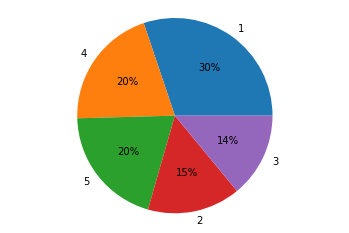

In [17]:
percent_pie_chart(df, 'note')

**Observation des variables catégorielles**

In [18]:
df.auteur.value_counts()

mikado-50419            4
mm-53953                4
pj-97010                4
tontonbubu-54321        4
lotus5-51217            3
                       ..
elya973-80260           1
jean-pierre-s-137446    1
sass-117513             1
marco14-138660          1
jesse-51459             1
Name: auteur, Length: 23675, dtype: int64

In [19]:
df.assureur.unique()

array(['Direct Assurance', "L'olivier Assurance", 'Matmut',
       'Néoliane Santé', 'APRIL', 'SantéVet', 'Mercer', 'Generali',
       'Allianz', 'APRIL Moto', 'Cegema Assurances', 'LCL', 'Afer',
       'Pacifica', 'SwissLife', 'MAAF', 'Solly Azar', 'GMF', 'AMV',
       'CNP Assurances', 'MAIF', 'Sogecap', 'Harmonie Mutuelle',
       'Mutuelle des Motards', 'MACIF', 'Eurofil', 'Active Assurances',
       'AXA', 'Sogessur', 'Ag2r La Mondiale', 'Mgen', "Zen'Up", 'MGP',
       'Intériale', 'Génération', 'Cardif', 'Santiane', 'Eca Assurances',
       'Groupama', "Assur O'Poil", 'MMA', 'MetLife', 'Crédit Mutuel',
       'Afi Esca', 'Gan', 'Magnolia', 'Suravenir', 'Assur Bon Plan',
       'AssurOnline', 'Carac', 'Mapa', 'Malakoff Humanis',
       'Euro-Assurance', 'Peyrac Assurances', 'Sma', 'Hiscox'],
      dtype=object)

<AxesSubplot:ylabel='assureur'>

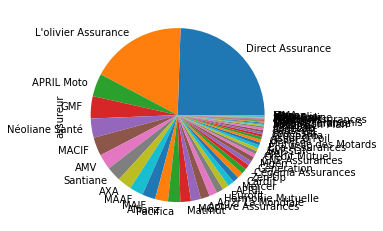

In [20]:
df.assureur.value_counts().plot.pie()

Faisons un pie chart plus lissible.

In [21]:
df.assureur.value_counts(normalize=True).sort_values(ascending=False)

Direct Assurance        0.244617
L'olivier Assurance     0.177903
APRIL Moto              0.042443
GMF                     0.041364
Néoliane Santé          0.035722
MACIF                   0.034394
AMV                     0.028544
Santiane                0.027300
AXA                     0.026096
MAAF                    0.025391
MAIF                    0.024520
Allianz                 0.023814
Pacifica                0.022943
Matmut                  0.019666
MGP                     0.018504
Active Assurances       0.016720
Ag2r La Mondiale        0.014521
Harmonie Mutuelle       0.012944
Eurofil                 0.011990
APRIL                   0.011741
Mercer                  0.011077
Cardif                  0.010994
Zen'Up                  0.010165
Cegema Assurances       0.008879
Génération              0.008796
Mgen                    0.008671
CNP Assurances          0.006099
Crédit Mutuel           0.006057
Afer                    0.005974
SwissLife               0.005725
Eca Assura

In [22]:
df.assureur.value_counts(normalize=True).loc[lambda x: x>0.02].index

Index(['Direct Assurance', 'L'olivier Assurance', 'APRIL Moto', 'GMF',
       'Néoliane Santé', 'MACIF', 'AMV', 'Santiane', 'AXA', 'MAAF', 'MAIF',
       'Allianz', 'Pacifica'],
      dtype='object')

In [23]:
def filter_percent_threshold(df, variable, threshold):
    df_ = df.copy()
    counts = df_[variable].value_counts(normalize=True)
    idx = counts[counts.lt(threshold)].index

    df_.loc[df_[variable].isin(idx), variable] = 'Autres'
    return df_

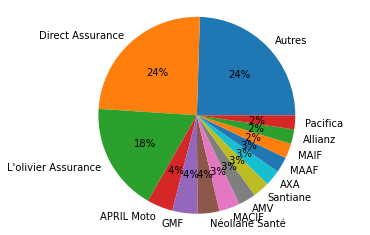

In [24]:
df_plot = filter_percent_threshold(df, 'assureur', 0.02)
percent_pie_chart(df_plot, 'assureur')

In [25]:
df.produit.unique()

array(['auto', 'sante', 'animaux', 'vie', 'moto', 'credit', 'habitation',
       'prevoyance', 'responsabilite-civile-professionnelle',
       'multirisque-professionnelle', 'assurances-professionnelles',
       'garantie-decennale', 'flotte-automobile'], dtype=object)

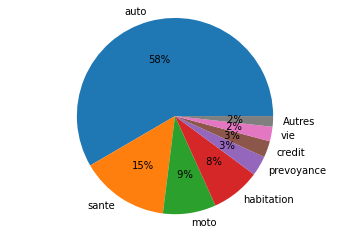

In [26]:
df_plot = filter_percent_threshold(df, 'produit', 0.02)
percent_pie_chart(df_plot, 'produit')

## Analyse variable-target

### Produit:

In [27]:
results = df.pivot_table(index='produit', columns='note', 
                     aggfunc={"note":['count']})
results

note                                
                                        count                                
note                                        1       2       3       4       5
produit                                                                      
animaux                                 223.0    70.0    33.0    21.0    27.0
assurances-professionnelles               6.0     2.0     NaN     NaN     NaN
auto                                   3021.0  2093.0  2158.0  3426.0  3378.0
credit                                  269.0    97.0    46.0    77.0   164.0
flotte-automobile                         1.0     NaN     NaN     NaN     NaN
garantie-decennale                       10.0     NaN     NaN     1.0     1.0
habitation                             1073.0   534.0   195.0    95.0    59.0
moto                                    318.0   267.0   267.0   548.0   705.0
multirisque-professionnelle               8.0     1.0     NaN     8.0     3.0
prevoyance                              522.0   119.0    80.0    34.0    35.0
responsabilite-civile-professionnelle     5.0     NaN     NaN     NaN     NaN
sante                                  1408.0   443.0   539.0   663.0   472.0
vie                                     407.0    90.0    63.0    12.0     6.0

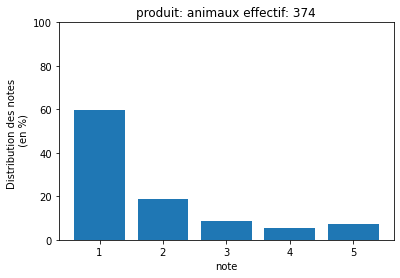

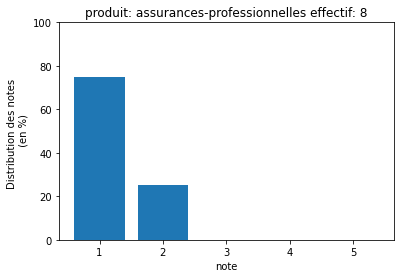

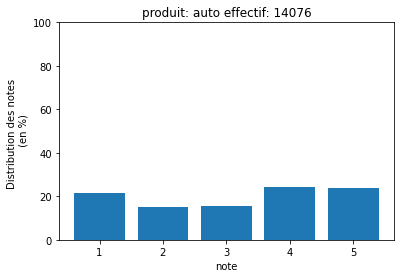

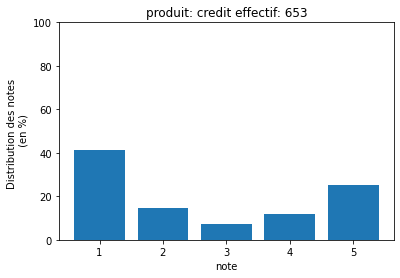

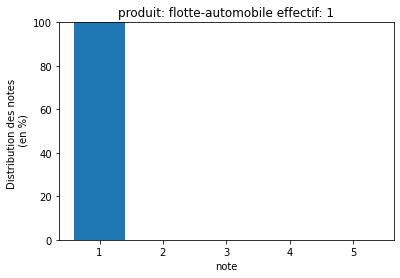

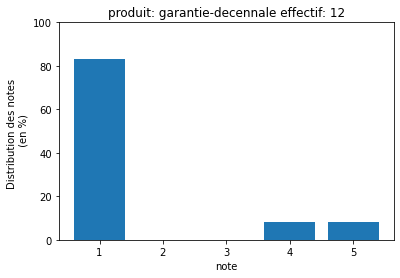

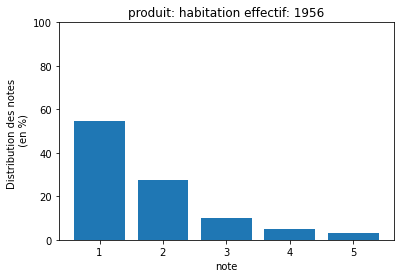

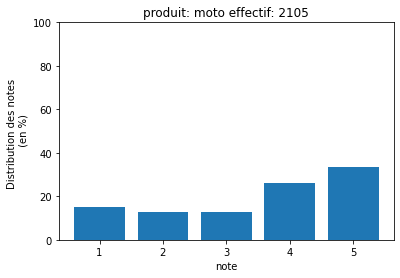

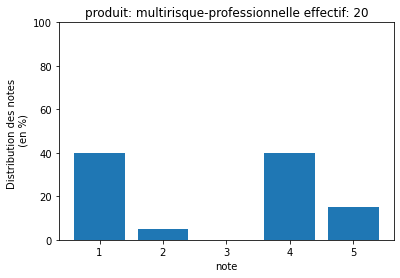

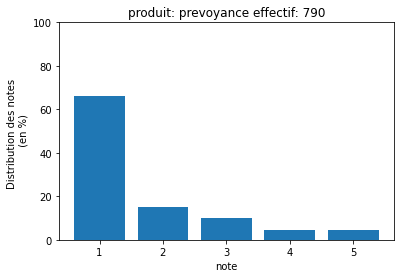

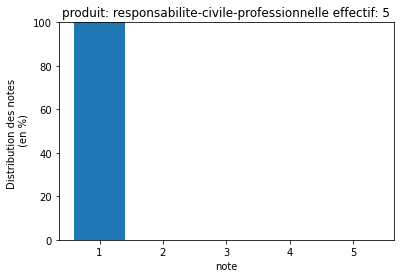

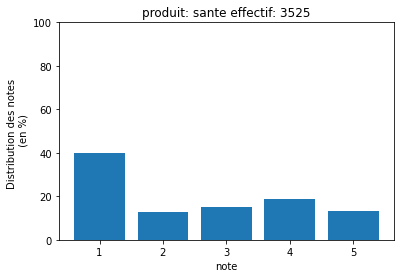

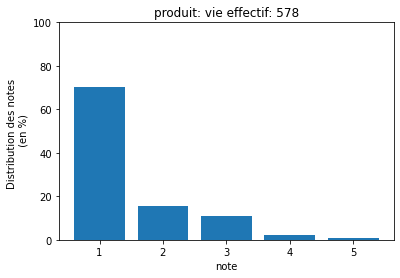

In [28]:
for produit in results.index:
    counts = pd.Series(results.loc[produit, :].values)
    counts = counts.fillna(0)
    eff = sum(counts)
    counts = 100*counts / eff
    
    fig, ax = plt.subplots()
    plt.bar(range(1,6), counts)
    ax.set_ylim(0,100)
    plt.title('produit: ' + produit + ' effectif: '+str(int(eff)))
    plt.ylabel('Distribution des notes \n (en %)')
    plt.xlabel('note')
    plt.show()

### Assureurs

In [29]:
df_plot = df[df.assureur.isin(df.assureur.value_counts(normalize=True).loc[lambda x: x>0.02].index)]
results = df_plot.pivot_table(index='assureur', columns='note', 
                     aggfunc={"note":['count']})
results

note                       
                    count                       
note                    1    2     3     4     5
assureur                                        
AMV                    74   86    80   186   262
APRIL Moto             56   70   152   340   405
AXA                   363  143    86    22    15
Allianz               383  112    51    18    10
Direct Assurance      959  767  1111  1577  1482
GMF                   215  220   180   227   155
L'olivier Assurance   383  332   530  1430  1613
MAAF                  290  189    86    31    16
MACIF                 423  250    81    43    32
MAIF                  314  145    69    41    22
Néoliane Santé        267  106   166   180   142
Pacifica              289  122    56    63    23
Santiane               85   57   140   217   159

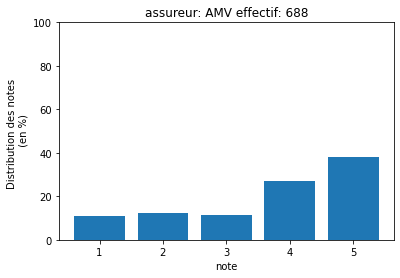

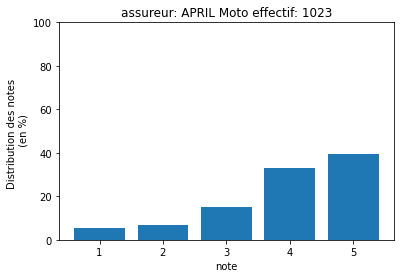

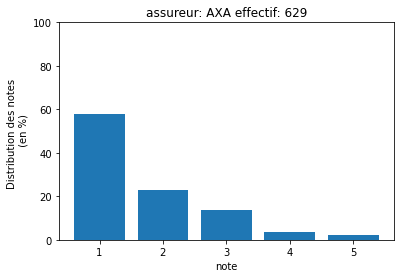

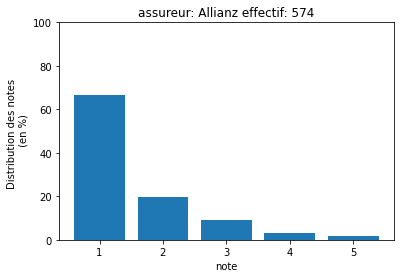

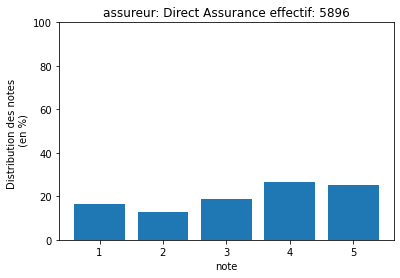

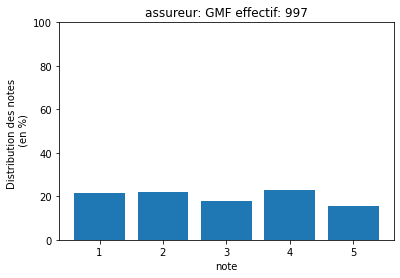

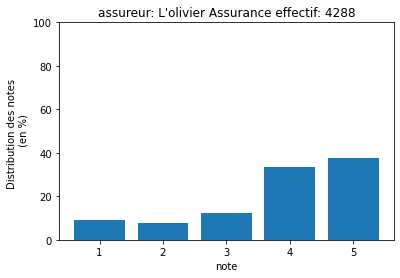

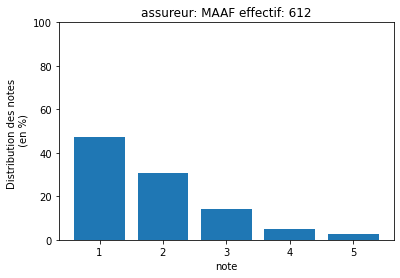

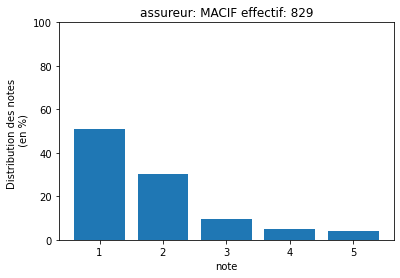

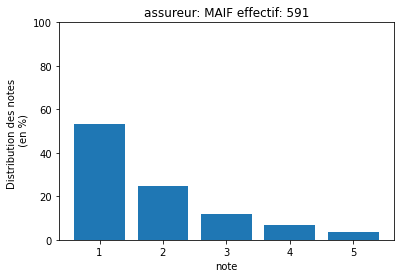

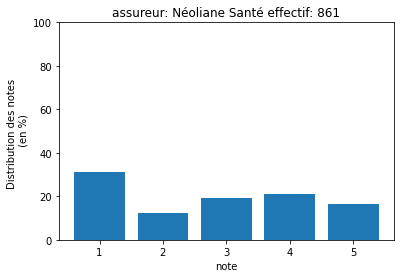

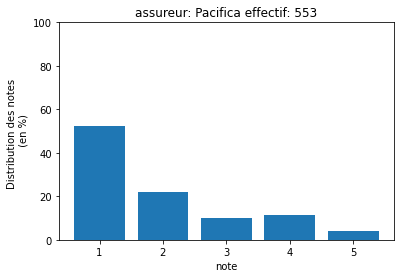

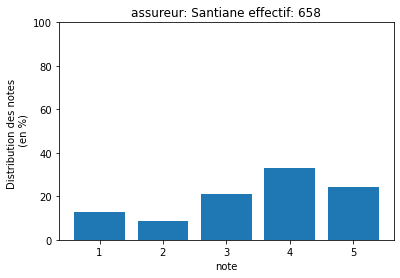

In [30]:
for assureur in results.index:
    counts = pd.Series(results.loc[assureur, :].values)
    counts = counts.fillna(0)
    eff = sum(counts)
    counts = 100*counts / eff
    
    fig, ax = plt.subplots()
    plt.bar(range(1,6), counts)
    ax.set_ylim(0,100)
    plt.title('assureur: ' + assureur + ' effectif: '+str(int(eff)))
    plt.ylabel('Distribution des notes \n (en %)')
    plt.xlabel('note')
    plt.show()

In [89]:
from sklearn.metrics import mean_squared_error

from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
import re

from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [32]:
def netoyage_text_avis(A):
    # on enlève les stopwords et les carractères spéciaux
    B = [ i for i in  re.sub("[^a-zà-ÿ]", " ", str(A)).split() if i not in stop_words_list]
    #C = [ i.replace(',','') for i in B]
    # On récupère le radical de chaque mot
    C = [[fr.stem(word) for word in word_tokenize(B[i])][0] for i in range(len(B))]
    # On reconstitue la phrase
    D = ' '.join(C)
    return D

In [36]:
data = df.copy()
data = data.dropna(axis=1)

In [65]:
stemmer = SnowballStemmer('french')
stop_words_list = stopwords.words("french")
fr = SnowballStemmer('french')

In [66]:
data['cleaned'] = data['avis'].apply(lambda x: netoyage_text_avis(x))

In [101]:
text_features = ['cleaned']
categorical_features = ['auteur', 'assureur', 'produit']

In [68]:
X = data.copy().drop(['note'], axis=1)
y = data.note.copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [91]:
MAX_FEAT_DESCP = 5000

In [132]:
categorical_features = ['auteur', 'assureur', 'produit']

In [149]:
categorical_pipeline = Pipeline(steps=[( 'onehot',OneHotEncoder(handle_unknown = 'ignore'))])

In [155]:
categories_countvec = [
    ( 'onehot_'+col, categorical_pipeline, [col] ) for col in categorical_features
]
categories_countvec

[('onehot_auteur',
  Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]),
  ['auteur']),
 ('onehot_assureur',
  Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]),
  ['assureur']),
 ('onehot_produit',
  Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]),
  ['produit'])]

In [173]:
pipelineNLP = Pipeline([
    ('vect', TfidfVectorizer(ngram_range=(1,1), stop_words=stop_words_list, sublinear_tf=True)),
    ('chi',  SelectKBest(chi2, k=1000)),
    ('clf', LinearSVC(C=1.0, penalty='l1', max_iter=3000, dual=False))
])

In [178]:
pipelineNLP.fit(X_train['cleaned'], y_train)

Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['au', 'aux', 'avec', 'ce', 'ces',
                                             'dans', 'de', 'des', 'du', 'elle',
                                             'en', 'et', 'eux', 'il', 'ils',
                                             'je', 'la', 'le', 'les', 'leur',
                                             'lui', 'ma', 'mais', 'me', 'même',
                                             'mes', 'moi', 'mon', 'ne', 'nos', ...],
                                 sublinear_tf=True)),
                ('chi',
                 SelectKBest(k=1000,
                             score_func=<function chi2 at 0x1590169d0>)),
                ('clf', LinearSVC(dual=False, max_iter=3000, penalty='l1'))])

In [174]:
preprocess = ColumnTransformer(
    categories_countvec +
    [
     ('avis_tfidf', pipelineNLP, 'cleaned')],
    remainder='drop')

In [175]:
model = make_pipeline(
    preprocess,
    SVC())

In [176]:
model

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('onehot_auteur',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['auteur']),
                                                 ('onehot_assureur',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['assureur']),
                                                 ('onehot_produit',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))...
                                                                   TfidfVectorizer(stop_words=['au',
                                                                                               'aux',
                                                                                               'avec',
                                                                                               'ce',
                                                                                               'ces',
                                                                                               'dans',
                                                                                               'de',
                                                                                               'des',
                                                                                               'du',
                                                                                               'elle',
                                                                                               'en',
                                                                                               'et',
                                                                                               'eux',
                                                                                               'il',
                                                                                               'ils',
                                                                                               'je',
                                                                                               'la',
                                                                                               'le',
                                                                                               'les',
                                                                                               'leur',
                                                                                               'lui',
                                                                                               'ma',
                                                                                               'mais',
                                                                                               'me',
                                                                                               'même',
                                                                                               'mes',
                                                                                               'moi',
                                                                                               'mon',
                                                                                               'ne',
                                                                                               'nos', ...],
          

In [177]:
model.fit(X_train, y_train)

TypeError: All estimators should implement fit and transform, or can be 'drop' or 'passthrough' specifiers. 'Pipeline(steps=[('vect',
                 TfidfVectorizer(stop_words=['au', 'aux', 'avec', 'ce', 'ces',
                                             'dans', 'de', 'des', 'du', 'elle',
                                             'en', 'et', 'eux', 'il', 'ils',
                                             'je', 'la', 'le', 'les', 'leur',
                                             'lui', 'ma', 'mais', 'me', 'même',
                                             'mes', 'moi', 'mon', 'ne', 'nos', ...],
                                 sublinear_tf=True)),
                ('chi',
                 SelectKBest(k=1000,
                             score_func=<function chi2 at 0x1590169d0>)),
                ('clf', LinearSVC(dual=False, max_iter=3000, penalty='l1'))])' (type <class 'sklearn.pipeline.Pipeline'>) doesn't.

In [168]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           1       0.59      0.91      0.72      1464
           2       0.44      0.04      0.07       768
           3       0.35      0.06      0.10       640
           4       0.41      0.45      0.43       988
           5       0.52      0.70      0.60       961

    accuracy                           0.52      4821
   macro avg       0.46      0.43      0.38      4821
weighted avg       0.48      0.52      0.45      4821



In [40]:
categorical_ct = ColumnTransformer(
    transformers=[
        ('cat', categorical_pipeline, categorical_features)
    ])

In [41]:
SVC_model = Pipeline(steps=[
        ('preprocessor', categorical_ct),
        ('svc', SVC())
    ])

In [42]:
fitted_SVC_model = SVC_model.fit(X_train, y_train)

In [43]:
y_pred = fitted_SVC_model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=1))

              precision    recall  f1-score   support

           1       0.54      0.76      0.63      1429
           2       0.75      0.00      0.01       791
           3       1.00      0.00      0.00       668
           4       0.27      0.44      0.34       956
           5       0.39      0.51      0.45       977

    accuracy                           0.42      4821
   macro avg       0.59      0.34      0.28      4821
weighted avg       0.56      0.42      0.34      4821

